In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pickle
import re
import seaborn as sns
import scipy
import statsmodels.api as sm
plt.style.use('ggplot')
# pd.options.display.float_format = '{:.2f}'.format
# #pd.reset_option('display.float_format')

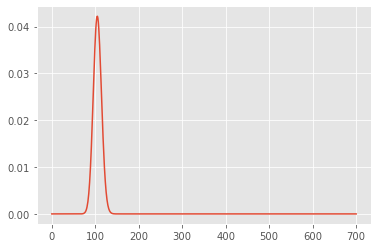

In [58]:
p=0.15
n=700
val = np.arange(0,n+1,1)
dist = [binom.pmf(r,n,p) for r in val]
plt.plot(dist)

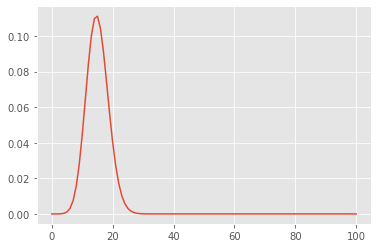

In [51]:
pt = np.linspace(0,100,101)
pmf = binom.pmf(pt,100,0.15)
plt.plot(pt,pmf)

In [2]:
#List of winners and all candidates during 2009, 2014 and 2019 (Download all candidate datasets)

url_2009 = 'https://myneta.info/ls2009/index.php?action=summary&subAction=candidates_analyzed&sort=candidate#summary'
url_2014 = 'https://myneta.info/ls2014/index.php?action=summary&subAction=candidates_analyzed&sort=candidate#summary'
url_2019 = 'https://myneta.info/LokSabha2019/index.php?action=summary&subAction=candidates_analyzed&sort=candidate#summary'
url_2009_w = 'https://myneta.info/ls2009/index.php?action=summary&subAction=winner_analyzed&sort=candidate#summary'
url_2014_w = 'https://myneta.info/ls2014/index.php?action=summary&subAction=winner_analyzed&sort=candidate#summary'
url_2019_w = 'https://myneta.info/LokSabha2019/index.php?action=summary&subAction=winner_analyzed&sort=candidate#summary'
all_data = []
lk_win = []

#Download the html pages and store as lists
for url in [url_2009,url_2014,url_2019]:
    html = requests.get(url).content
    df_list = pd.read_html(html)
    all_data.append(df_list)

for url in [url_2009_w,url_2014_w,url_2019_w]:
    html = requests.get(url).content
    df_list = pd.read_html(html)
    lk_win.append(df_list)

In [203]:
#Collect state wise tables for 2014
state_url = 'https://myneta.info/ls2014/index.php?action=show_constituencies&state_id='
state_map = {1:'Andhra_Pradesh',2:'Arunachal_Pradesh',3:'Assam',4:'Bihar',5:'Goa',6:'Gujarat',
             7:'Haryana',8:'Himachal_Pradesh',9:'Jammu_Kashmir',10:'Karnataka',11:'Kerala',
             12:'Madhya_Pradesh',13:'Maharashtra',14:'Manipur',15:'Meghalaya',16:'Mizoram',
             17:'Nagaland',18:'Orissa',19:'Punjab',20:'Rajasthan',21:'Sikkim',22:'Tamil_Nadu',
             23:'Tripura',24:'Uttar_Pradesh',25:'West_Bengal',26:'Chattisgarh',27:'Jharkhand',
             28:'Uttarakhand',29:'Andaman_Nicobar',30:'Chandigarh',31:'Dadra_Nagar',32:'Diu_Daman',
             33:'NCR_Delhi',34:'Lakshadweep',35:'Puducherry',36:'Telangana'}

state_wise = {}
for a in state_map.keys():
    url = state_url + str(a)
    html = requests.get(url).content
    df = pd.read_html(html)
    state_wise[state_map[a]] = df
with open('state_level.pkl', 'wb') as f:
    pickle.dump(state_wise,f)

In [273]:
# with open('all_data.pkl', 'wb') as f:
#     pickle.dump(all_data,f)
# with open('lk_win.pkl', 'wb') as f:
#     pickle.dump(lk_win,f)

# with open('all_data.pkl', 'rb') as f:
#     test = pickle.load(f)

In [218]:
#Clean collected data
def data_clean(data):
    dict_clean = {}
    years = ['2009','2014','2019']
    p = '[^0-9]'
    a = ['Candidate∇', 'Criminal Cases','Total Assets', 'Liabilities']
    b = ['Candidate', 'Criminal_Case','Assets', 'Liabilities']
    cols = dict(zip(a,b))
    #for a in range(len(data)):
    for a in data.keys():
        df = data[a][2].copy()
        #df.columns = df.columns.get_level_values(1)
        #df = df.drop(['Sno','Unnamed: 8_level_1','Unnamed: 9_level_1'],axis=1)
        df = df.drop(['Sno'],axis=1)
        df.loc[df['Total Assets']=='Nil','Total Assets'] = 0
        df['Total Assets'] = pd.to_numeric(df['Total Assets'].str.split('~').str[0].str.replace(p,''))
        df['Total Assets']= df['Total Assets'].fillna(0)
        df['Liabilities'] = pd.to_numeric(df['Liabilities'].str.split('~').str[0].str.replace(p,''))
        df.rename(columns=cols,inplace=True)
        df['Net_Assets'] = df['Assets'] - df['Liabilities']
        #dict_clean[years[a]] = df
        dict_clean[a] = df
    return dict_clean

In [224]:
412115# state_wise_clean = data_clean(state_wise)
# with open('state_level_clean.pkl', 'wb') as f:
#     pickle.dump(state_wise_clean,f)

In [102]:
all_candidates = data_clean(all_data)
win_candidates = data_clean(lk_win)
years = ['2009','2014','2019']
final_data = {}
cols = ['Candidate', 'Constituency', 'Party', 'Criminal_Case', 'Education',
        'Assets', 'Liabilities', 'Net_Assets']
for a in range(len(all_candidates)):
    df_all = all_candidates[years[a]].copy()
    df_win = win_candidates[years[a]].copy()
    df_all['Winners'] = 0
    df_win['Winners'] = 1
    ct = pd.concat([df_all,df_win])
    ct = ct.groupby(cols).max()['Winners'].reset_index()
    final_data[years[a]] = ct
with open('all_candidates.pkl', 'wb') as f:
    pickle.dump(all_data,f)
with open('win_candidates.pkl', 'wb') as f:
    pickle.dump(lk_win,f)
with open('final_candidate_list.pkl', 'wb') as f:
    pickle.dump(final_data,f)

In [24]:
grad_h = ['Graduate','Post Graduate', 'Graduate Professional','Doctorate']
# We are assuming some ambiguous values such as not given, literate, others as below the graduate level

df_2009['criminal_charge'] = np.where(df_2009['Criminal_Case']>0,1,0)
df_2009['grad_h'] = np.where(df_2009['Education'].isin(grad_h), 1, 0)

df_2014['criminal_charge'] = np.where(df_2014['Criminal_Case']>0,1,0)
df_2014['grad_h'] = np.where(df_2014['Education'].isin(grad_h), 1, 0)

df_2019['criminal_charge'] = np.where(df_2019['Criminal_Case']>0,1,0)
df_2019['grad_h'] = np.where(df_2019['Education'].isin(grad_h), 1, 0)

In [241]:
# with open('state_level_clean.pkl', 'wb') as f:
#     pickle.dump(state_wise_clean,f)

In [2]:
# with open('all_2009.pkl', 'wb') as f:
#     pickle.dump(df_2009,f)
# with open('all_2014.pkl', 'wb') as f:
#     pickle.dump(df_2014,f)
# with open('all_2019.pkl', 'wb') as f:
#     pickle.dump(df_2019,f)
# df_2009 = final_data['2009']
# df_2014 = final_data['2014']
# df_2019 = final_data['2019']
with open('all_2009.pkl', 'rb') as f:
    df_2009 = pickle.load(f)
with open('all_2014.pkl', 'rb') as f:
    df_2014 = pickle.load(f)
with open('all_2019.pkl', 'rb') as f:
    df_2019 = pickle.load(f)

In [278]:
df_2009.head()

,Candidate,Constituency,Party,Criminal_Case,Education,Assets,Liabilities,Net_Assets,Winners,criminal_charge,grad_h
0,"""SUDAROLI"" MURUGAN S. B.COM.,",Tirunelveli,IND,0,Not Given,54652.0,67100,-12448.0,0,0,0
1,(AIDS MAN) PRAKASH TATERAO LANDGE,Nanded,IND,0,Graduate,350000.0,0,350000.0,0,0,1
2,A Arokiasamy,Palakkad,IND,0,10th Pass,32000.0,0,32000.0,0,0,0
3,A B SINGH,Chittorgarh,BSP,0,Post Graduate,3347551.0,0,3347551.0,0,0,1
4,A Gumpa Swamy,Araku,IND,0,Illiterate,0.0,0,0.0,0,0,0


# Hypotheses to be tested with candidate data

1. The net assets of candidates has increased in 2014 compared to 2009. 
2. The proportion of candidates with a criminal record has increased in 2014 compared to 2009. 
3. The proportion of candidates with a graduate level education or higher has increased in 2014 compared to 2009
4. Is having a criminal case registered related to a candidate's level of education ?
5. The proportion of winners with a criminal record has increased from 2009 to 2014
6. The proportion of winners with a graduate level education or higher has gone up between 2009 to 2014

### 1. The net assets of all candidates has increased in 2014 compared to 2009. 

1. We can use a 1-sample t-test to test this hypothesis. Assume we know the mean net asset value for candidates in 2009
    This test requires the following conditions:
    1. Choosing a random sample
    2. Independence condition (Choose less than or equal to 10% of the population)
    3. Normal condition (sampling dist of sample mean can be approximated as normal) if any of following is satisfyed
        1. If parent population is normal
        2. Sample size >= 30
        3. Sample distribution is not skewed or has outliers
        
1. Null Hypothesis: The average net assets for 2014 are equal to the average net assets for 2009
2. Alternate Hypothesis: The average net assets in 2014 are higher than in 2009 (1-tailed test)
- Significance Level: 5%

In [162]:
mean_assets_2009 = df_2009['Net_Assets'].mean()
sample_2014 = np.array(df_2014['Net_Assets'].sample(700))
t_all_asset, p_all_asset = scipy.stats.ttest_1samp(a = sample_2014, popmean = mean_assets_2009, alternative='greater')
print('t-statistic: ',t_all_asset,'p-value: ',p_all_asset)

t-statistic:  2.364121120207607 p-value:  0.009172686169212841


In [166]:
t = (np.mean(sample_2014) - mean_assets_2009)/(np.std(sample_2014)/np.sqrt(700))
print(t,mean_assets_2009,np.mean(sample_2014))

2.365811589583576 16595480.773693884 30287894.014285713


The pvalue obtained with this test is below the chosen significance level. Thus we can reject the null hypothesis. Thus the alternative hypothesis that average net assets have increased in 2014 compared to 2009 can be accepted

### 2. The proportion of candidates with a criminal record has increased in 2014 compared to 2009. 

1. We can use a 1-sample z-test to test this hypothesis. We know the proportion of candidates in 2009 with crime records
    This test requires the following conditions:
    1. Choosing a random sample
    2. Independence condition (Choose less than or equal to 10% of the population)
    3. Normal condition (sampling dist of sample mean can be approximated as normal) if the following is satisfyed
        1. n*p and n*(1-p) >= 10
        
1. Null Hypothesis: The proportion of candidates with a criminal record for 2014 is the equal to that in 2009
2. Alternate Hypothesis: The proportion of candidates with a criminal record has increased between 2009 and 2014 (1 tailed test)
- Significance Level: 5%

In [22]:
#0.1*len(df_2009), 0.1*(len(df_2014))

In [201]:
prop_2009_c = df_2009['criminal_charge'].value_counts(normalize=True)[1]
prop_sample_2014_c = df_2014['criminal_charge'].sample(700)

#Check normal condition
print('n*p',len(prop_sample_2014_c)*prop_2009_c)
print('n*(1-p)',len(prop_sample_2014_c)*(1-prop_2009_c))

n*p 100.89262273562615
n*(1-p) 599.1073772643739


In [202]:
df_2009['criminal_charge'].value_counts(normalize=True),df_2014['criminal_charge'].value_counts(normalize=True)

(0    0.855868
 1    0.144132
 Name: criminal_charge, dtype: float64,
 0    0.828906
 1    0.171094
 Name: criminal_charge, dtype: float64)

In [203]:
z_all_c, p_all_c = sm.stats.proportions_ztest(count = prop_sample_2014_c.sum(),nobs=len(prop_sample_2014_c),
                                               value=prop_2009_c,alternative='larger')
print('z-statistic: ',z_all_c,'p-value: ',p_all_c)

z-statistic:  1.4390253591672493 p-value:  0.07507166896701442


In [204]:
prop_sample_2014_c.value_counts(normalize=True)

0    0.835714
1    0.164286
Name: criminal_charge, dtype: float64

The p value is above our 5% significance level. Thus we fail to reject the null hypothesis which states that the proportion of criminal records is the same between 2009 and 2014

### 3. The proportion of candidates with a graduate level eduction or higher has changed between 2009 and 2014. 

1. We can use a 1-sample z-test to test this hypothesis. We know the proportion of candidates in 2009 with a graduate level education or higher
    This test requires the following conditions:
    1. Choosing a random sample
    2. Independence condition (Choose less than or equal to 10% of the population)
    3. Normal condition (sampling dist of sample mean can be approximated as normal) if the following is satisfyed
        1. n*p and n*(1-p) >= 10
        
1. Null Hypothesis: The proportion of candidates with a graduate level education or higher is the same between 2009 and 2014
2. Alternate Hypothesis: The proportion of candidates with a graduate level education or higher between 2009 and 2014 is not the same (2-tailed test)
- Significance Level: 5%

In [236]:
df_2009['grad_h'].value_counts(normalize=True), df_2014['grad_h'].value_counts(normalize=True)

(0    0.566553
 1    0.433447
 Name: grad_h, dtype: float64,
 0    0.509505
 1    0.490495
 Name: grad_h, dtype: float64)

In [237]:
prop_sample_2014_g.value_counts(normalize=True)

0    0.517143
1    0.482857
Name: grad_h, dtype: float64

In [234]:
prop_2009_g = df_2009['grad_h'].value_counts(normalize=True)[1]
prop_sample_2014_g = df_2014['grad_h'].sample(700)

#Check normal condition
print('n*p',len(prop_sample_2014_g)*prop_2009_g)
print('n*(1-p)',len(prop_sample_2014_g)*(1-prop_2009_g))

n*p 303.4129692832765
n*(1-p) 396.5870307167235


In [235]:
z_all_g, p_all_g = sm.stats.proportions_ztest(count = prop_sample_2014_g.sum(),nobs=len(prop_sample_2014_g),
                                               value=prop_2009_g,alternative='two-sided')
print('z-statistic: ',z_all_g,', p-value: ',p_all_g)

z-statistic:  2.6160718292597442 , p-value:  0.008894784374077367


In [222]:
z_all_g, p_all_g = sm.stats.proportions_ztest(count = prop_sample_2014_g.sum(),nobs=len(prop_sample_2014_g),
                                               value=prop_2009_g,alternative='two-sided')
print('z-statistic: ',z_all_g,', p-value: ',p_all_g)

z-statistic:  1.636004956710782 , p-value:  0.10183855001541076


The p value is below our 5% significance level. Thus we can reject the null hypothesis and accept the alternate hypothesis that the number of candidates with a graduate level education or higher has changed between 2009 and 2014

## Permutation Tests

We can conduct two tailed permutation tests either between different years or between individual states for 2014 on the three criteria of net assets, criminal charges and graduate level education or higher

Below are examples run between Maharashtra/Kerala, Maharashtra/Uttar Pradesh, Uttar Pradesh/Kerala and 2009/2014, 2014/2019

In [151]:
#Bootstrap Test
# def bs_rep_1samp(arr1,null_mean,size,bs):
#     #arr1 = arr1.sample(size)
#     obs_mean = np.mean(arr1)
#     arr1_shift = arr1 - np.mean(arr1) + null_mean
#     bs_rep = np.empty(bs)
#     bs_t = np.empty(bs)
#     for a in range(bs):
#         arr_bs = np.random.choice(arr1_shift,size)
#         bs_rep[a] = np.mean(arr_bs)
#         bs_t[a] = (np.mean(arr_bs) - obs_mean) / (np.std(arr_bs)/np.sqrt(size))
# #     if greater = True:
# #         p_val = 
#     plt.hist(bs_rep)
#     #print(obs_mean)
#     plt.axvline(obs_mean,linewidth=1.5,color='r')
#     return bs_rep, bs_t

def bs_rep_2samp(arr1,arr2,size1,size2,bs):
    #arr1 = arr1.sample(size)
    cm_mean = np.mean(np.concatenate((arr1,arr2)));
    obs_mean = np.mean(arr1) - np.mean(arr2);
    arr1_shift = arr1 - np.mean(arr1) + cm_mean
    arr2_shift = arr2 - np.mean(arr2) + cm_mean
    bs_rep = np.empty(bs)
    for a in range(bs):
        arr_1_bs, arr_2_bs = np.random.choice(arr1_shift,size1), np.random.choice(arr2_shift,size2)
        bs_rep[a] = np.mean(arr_1_bs) - np.mean(arr_2_bs)
    p_val = np.sum(bs_rep>=obs_mean)/bs
    #print(obs_mean)
    
    plt.figure(figsize=[10,6])
    plt.hist(bs_rep)
    plt.xlabel('Test Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of bootstapped test statistic')
    plt.axvline(obs_mean,linewidth=1.5,color='b')
    
    print('p-value: ',p_val)
    return bs_rep

#Functions to permute samples and run a 2-sample permutation test
def perm_sample(arr1,arr2):
    data = np.concatenate((arr1,arr2))
    perm_data = np.random.permutation(data)
    arr1_p = perm_data[:len(arr1)]
    arr2_p = perm_data[len(arr1):]
    return arr1_p, arr2_p

def perm_test_2_samp(arr1,arr2,size=1000):
    perm_repl = np.empty(size)
    obs_stat = np.abs(np.mean(arr1) - np.mean(arr2))
    print(obs_stat)
    for a in range(size):
        
        arr1_p, arr2_p = perm_sample(arr1,arr2)
        perm_repl[a] = np.abs(np.mean(arr1_p) - np.mean(arr2_p))
        
    #p_val = (np.sum(perm_repl>=obs_stat) + np.sum(perm_repl<=-obs_stat)) /len(perm_repl)
    p_val = np.sum(perm_repl>=obs_stat) / len(perm_repl)
    
    if p_val<0.05:
        print('Reject Null Hypothesis as p-value ',p_val,'< alpha=0.05')
    else:
        print('Fail to reject Null Hypothesis as p-value ',p_val,'> alpha=0.05')
    plt.figure(figsize=[10,6])
    plt.hist(perm_repl);
    plt.xlabel('Test Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of permuted test statistic')
    plt.axvline(obs_stat,linewidth=1.5,color='b')
    return perm_repl, p_val

In [3]:
with open('state_level_clean.pkl', 'rb') as f:
    state_wise_clean = pickle.load(f)
df_Maharashtra = state_wise_clean['Maharashtra']
df_Uttar_Pradesh = state_wise_clean['Uttar_Pradesh']
df_Tamil_Nadu = state_wise_clean['Tamil_Nadu']
df_Karnataka = state_wise_clean['Karnataka']
df_Gujarat = state_wise_clean['Gujarat']
df_Bihar = state_wise_clean['Bihar']
df_Rajasthan = state_wise_clean['Rajasthan']
df_Kerala = state_wise_clean['Kerala']
df_West_Bengal = state_wise_clean['West_Bengal']

In [4]:
mh_2014_assets = np.array(df_Maharashtra['Net_Assets'])
kr_2014_assets = np.array(df_Kerala['Net_Assets'])
up_2014_assets = np.array(df_Uttar_Pradesh['Net_Assets'])
gj_2014_assets = np.array(df_Gujarat['Net_Assets'])

mh_2014_cr = np.array(df_Maharashtra['criminal_charge'])
kr_2014_cr = np.array(df_Kerala['criminal_charge'])
up_2014_cr = np.array(df_Uttar_Pradesh['criminal_charge'])
gj_2014_cr = np.array(df_Gujarat['criminal_charge'])

mh_2014_g = np.array(df_Maharashtra['grad_h'])
kr_2014_g = np.array(df_Kerala['grad_h'])
up_2014_g = np.array(df_Uttar_Pradesh['grad_h'])
gj_2014_g = np.array(df_Gujarat['grad_h'])

18395667.22954672
Reject Null Hypothesis as p-value  0.00874 < alpha=0.05


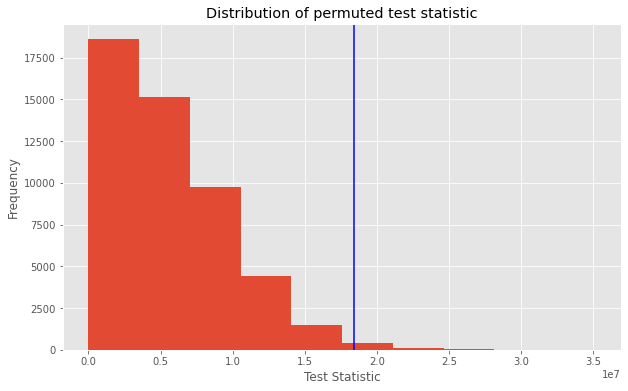

In [280]:
mhkr_assets, p_val_mhkr_assets = perm_test_2_samp(mh_2014_assets,kr_2014_assets,size=50000)
#plt.savefig('MH_KR_assets.png')

0.08249241679839367
Reject Null Hypothesis as p-value  0.00536 < alpha=0.05


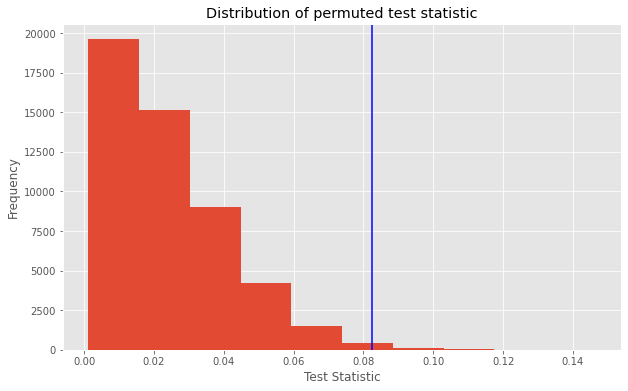

In [273]:
mhkr_cr, p_val_mhkr_cr = perm_test_2_samp(mh_2014_cr,kr_2014_cr,size=50000)
plt.savefig('MH_KR_cr.png')

0.03732644080830522
Fail to reject Null Hypothesis as p-value  0.29372 > alpha=0.05


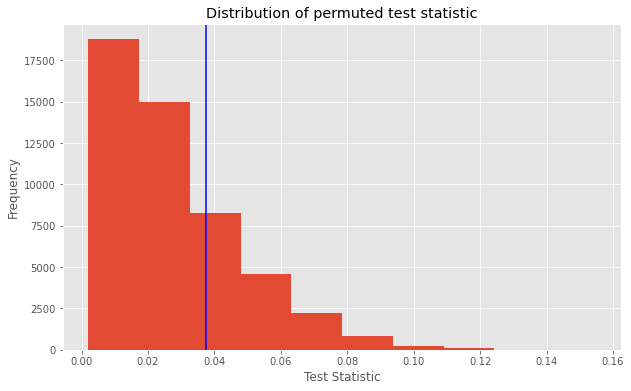

In [274]:
mhkr_g, p_val_mhkr_g = perm_test_2_samp(mh_2014_g,kr_2014_g,size=50000)
plt.savefig('MH_KR_gr.png')

2814705.015758492
Fail to reject Null Hypothesis as p-value  0.6239 > alpha=0.05


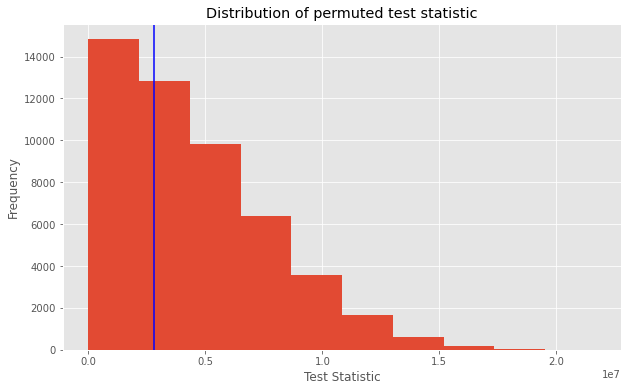

In [294]:
mhup_assets, p_val_mhup_assets = perm_test_2_samp(mh_2014_assets,up_2014_assets,size=50000)

0.013285175050372605
Fail to reject Null Hypothesis as p-value  0.47338 > alpha=0.05


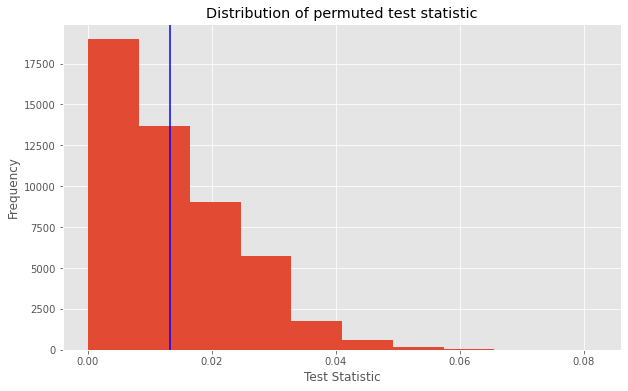

In [295]:
mhup_cr, p_val_mhup_cr = perm_test_2_samp(mh_2014_cr,up_2014_cr,size=50000)

0.042134391525080694
Fail to reject Null Hypothesis as p-value  0.05608 > alpha=0.05


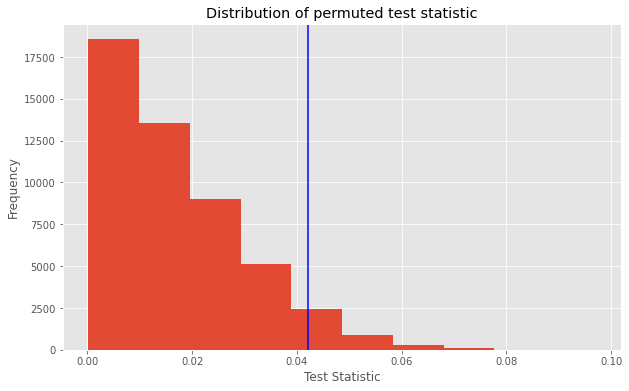

In [296]:
mhup_g, p_val_mhup_g = perm_test_2_samp(mh_2014_g,up_2014_g,size=50000)

21210372.24530521
Reject Null Hypothesis as p-value  0.01412 < alpha=0.05


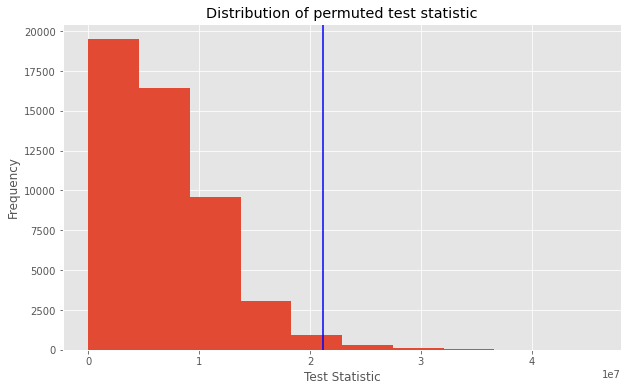

In [297]:
krup_assets, p_val_krup_assets = perm_test_2_samp(kr_2014_assets,up_2014_assets,size=50000)

0.09577759184876627
Reject Null Hypothesis as p-value  0.00076 < alpha=0.05


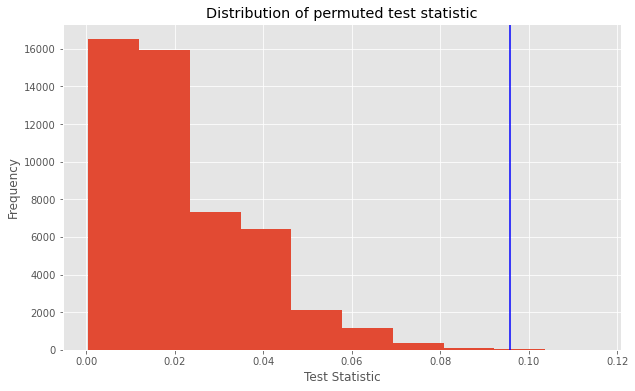

In [298]:
krup_cr, p_val_krup_cr = perm_test_2_samp(kr_2014_cr,up_2014_cr,size=50000)

0.07946083233338591
Reject Null Hypothesis as p-value  0.02094 < alpha=0.05


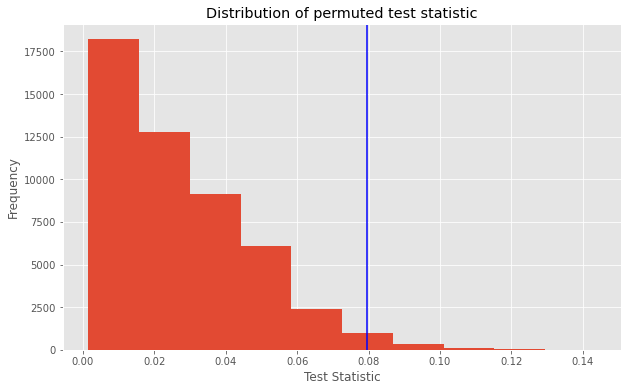

In [299]:
krup_g, p_val_krup_g = perm_test_2_samp(kr_2014_g,up_2014_g,size=50000)

14345791.890036102
Reject Null Hypothesis as p-value  0.02196 < alpha=0.05


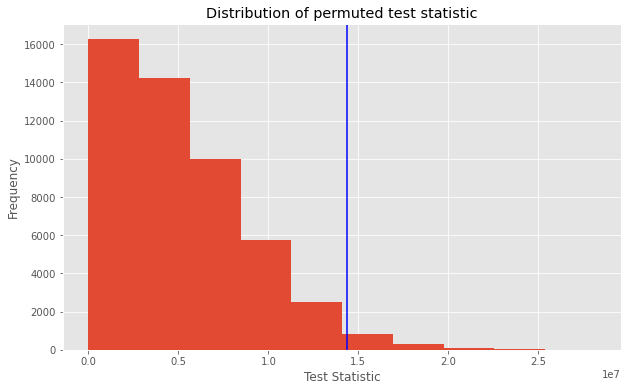

In [300]:
mhgj_assets, p_val_mhgj_assets = perm_test_2_samp(mh_2014_assets,gj_2014_assets,size=50000)

0.0006782062961838142
Fail to reject Null Hypothesis as p-value  1.0 > alpha=0.05


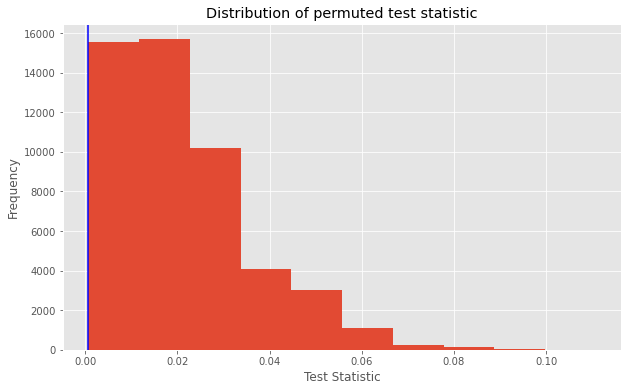

In [301]:
mhgj_cr, p_val_mhgj_cr = perm_test_2_samp(mh_2014_cr,gj_2014_cr,size=50000)

In [259]:
df_Maharashtra['criminal_charge'].value_counts(normalize=True), df_Gujarat['criminal_charge'].value_counts(normalize=True)

(0    0.801124
 1    0.198876
 Name: criminal_charge, dtype: float64,
 0    0.801802
 1    0.198198
 Name: criminal_charge, dtype: float64)

0.17048621655363227
Reject Null Hypothesis as p-value  0.0 < alpha=0.05


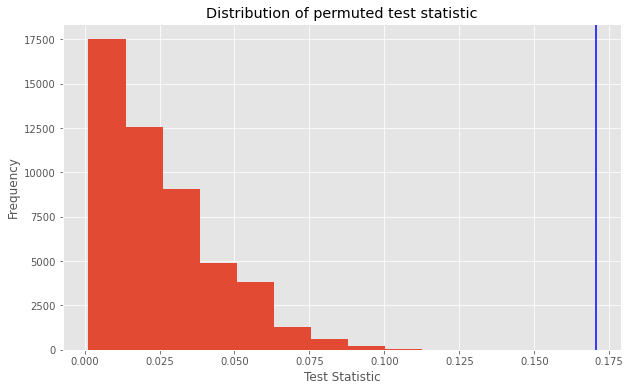

In [302]:
mhgj_g, p_val_mhgj_g = perm_test_2_samp(mh_2014_g,gj_2014_g,size=50000)

In [864]:
df_Maharashtra['grad_h'].value_counts(normalize=True), df_Gujarat['grad_h'].value_counts(normalize=True)

(0    0.529213
 1    0.470787
 Name: grad_h, dtype: float64,
 0    0.6997
 1    0.3003
 Name: grad_h, dtype: float64)

In [303]:
assets_2009 = df_2009['Net_Assets']
assets_2014 = df_2014['Net_Assets']
assets_2019 = df_2019['Net_Assets']

cr_2009 = df_2009['criminal_charge']
cr_2014 = df_2014['criminal_charge']
cr_2019 = df_2019['criminal_charge']

grad_2009 = df_2009['grad_h']
grad_2014 = df_2014['grad_h']
grad_2019 = df_2019['grad_h']

28640662.558745794
Reject Null Hypothesis as p-value  0.0 < alpha=0.05


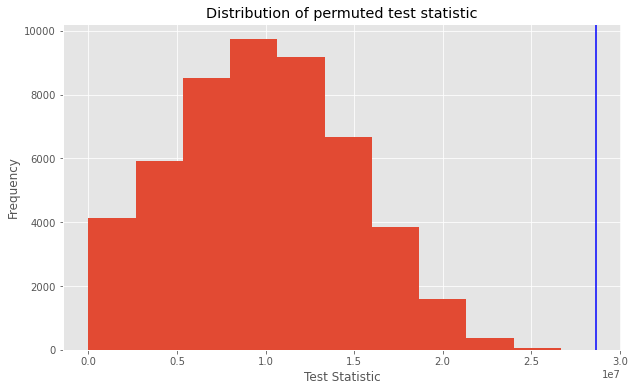

In [304]:
assets_0914, p_val_assets_0914 = perm_test_2_samp(assets_2009,assets_2014,size=50000)

0.02696200303461785
Reject Null Hypothesis as p-value  0.0 < alpha=0.05


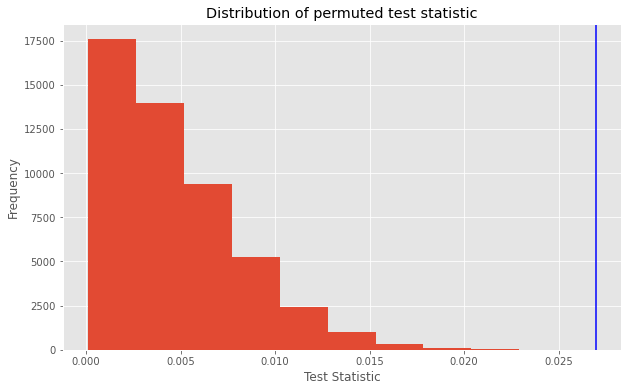

In [305]:
cr_0914, p_val_cr_0914 = perm_test_2_samp(cr_2009,cr_2014,size=50000)

0.057047660955648005
Reject Null Hypothesis as p-value  0.0 < alpha=0.05


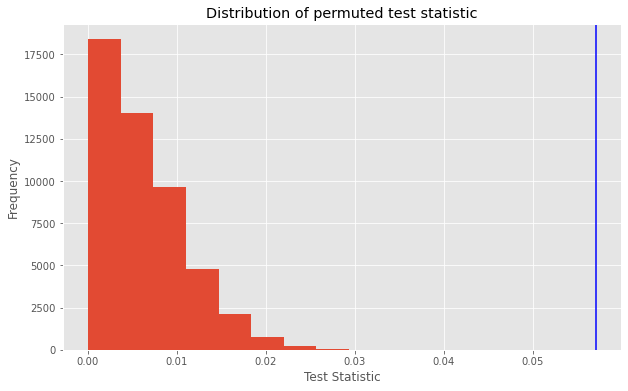

In [306]:
g_0914, p_val_g_0914 = perm_test_2_samp(grad_2009,grad_2014,size=50000)

9354718.045791447
Fail to reject Null Hypothesis as p-value  0.51178 > alpha=0.05


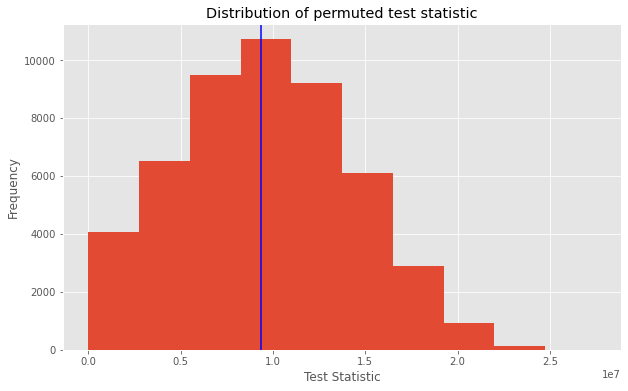

In [307]:
assets_1419, p_val_assets_1419 = perm_test_2_samp(assets_2014,assets_2019,size=50000)

0.018244376282316954
Reject Null Hypothesis as p-value  0.00278 < alpha=0.05


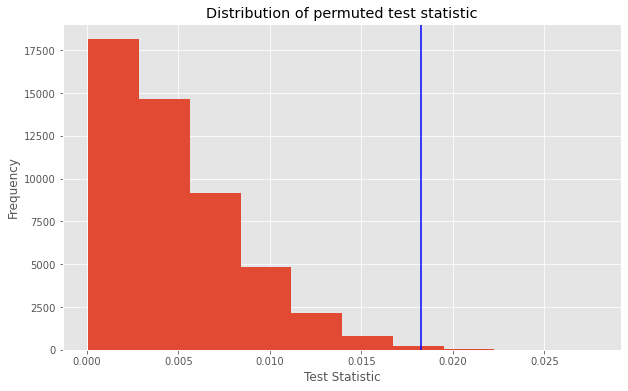

In [308]:
cr_1419, p_val_cr_1419 = perm_test_2_samp(cr_2014,cr_2019,size=50000)

0.009604641752224918
Fail to reject Null Hypothesis as p-value  0.22772 > alpha=0.05


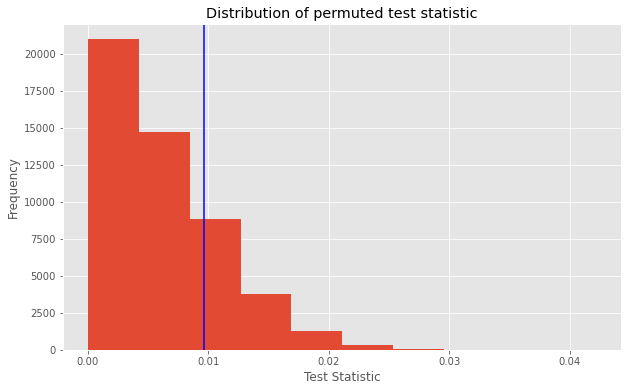

In [309]:
g_1419, p_val_g_1419 = perm_test_2_samp(grad_2014,grad_2019,size=50000)

In [310]:
win_2009 = df_2009[df_2009['Winners']==1][['criminal_charge','Net_Assets','grad_h']]
win_2014 = df_2014[df_2014['Winners']==1][['criminal_charge','Net_Assets','grad_h']]
win_2019 = df_2019[df_2019['Winners']==1][['criminal_charge','Net_Assets','grad_h']]

81682035.6517128
Reject Null Hypothesis as p-value  0.0 < alpha=0.05


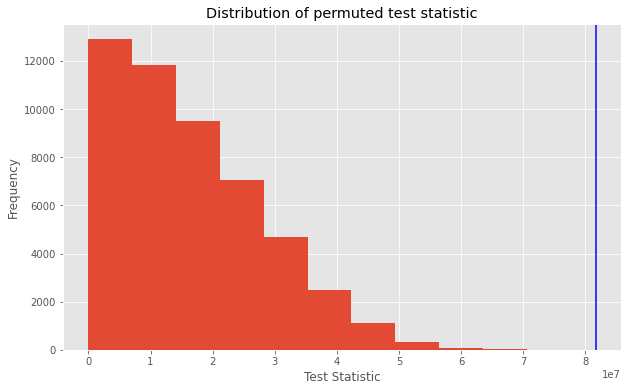

In [311]:
w_0914_assets, p_val_0914_assets = perm_test_2_samp(np.array(win_2009['Net_Assets']),
                                                    np.array(win_2014['Net_Assets']),size=50000)

0.04112577106394433
Fail to reject Null Hypothesis as p-value  0.16866 > alpha=0.05


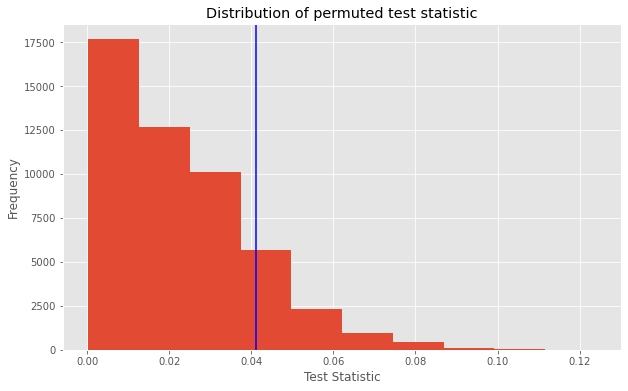

In [312]:
w_0914_cr, p_val_0914_cr = perm_test_2_samp(np.array(win_2009['criminal_charge']),
                                                    np.array(win_2014['criminal_charge']),size=50000)

0.011788160140508874
Fail to reject Null Hypothesis as p-value  0.67216 > alpha=0.05


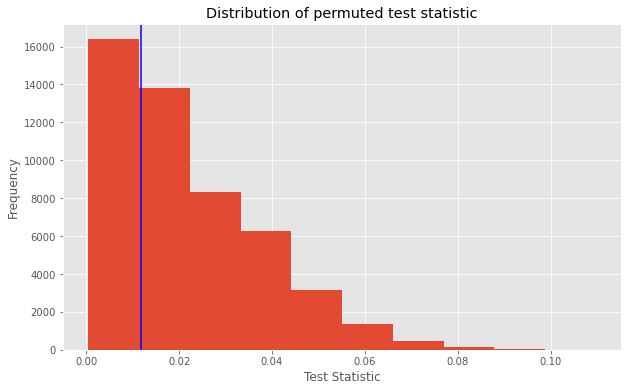

In [313]:
w_0914_g, p_val_0914_g = perm_test_2_samp(np.array(win_2009['grad_h']),
                                                    np.array(win_2014['grad_h']),size=50000)

41757962.26579861
Fail to reject Null Hypothesis as p-value  0.12488 > alpha=0.05


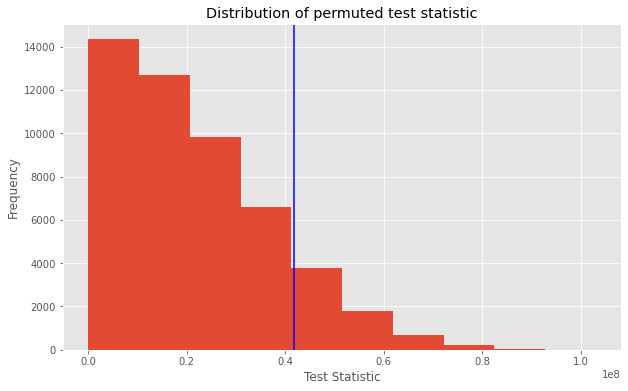

In [314]:
w_1419_assets, p_val_1419_assets = perm_test_2_samp(np.array(win_2014['Net_Assets']),
                                                    np.array(win_2019['Net_Assets']),size=50000)

0.09161659084243334
Reject Null Hypothesis as p-value  0.00206 < alpha=0.05


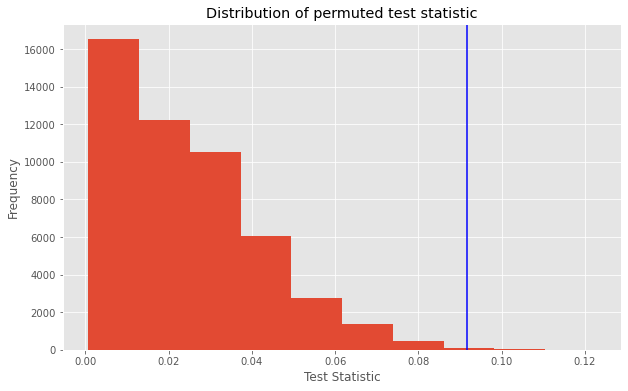

In [315]:
w_1419_cr, p_val_1419_cr = perm_test_2_samp(np.array(win_2014['criminal_charge']),
                                                    np.array(win_2019['criminal_charge']),size=50000)

0.017979551329709187
Fail to reject Null Hypothesis as p-value  0.53388 > alpha=0.05


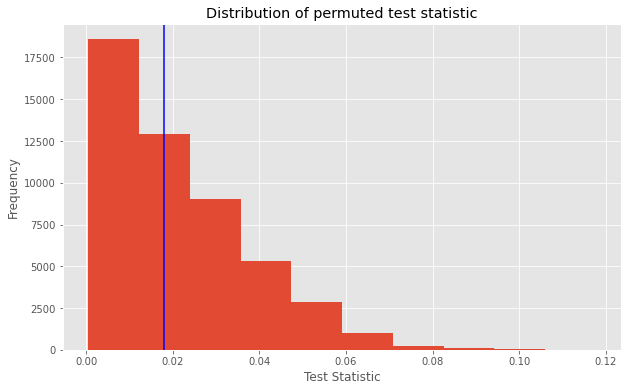

In [316]:
w_1419_g, p_val_1419_g = perm_test_2_samp(np.array(win_2014['grad_h']),
                                                    np.array(win_2019['grad_h']),size=50000)

Comparing difference between winners and non-winners of 2009 in terms of assets, criminal charges and graduate level education or other. We try both 2-sample t/z tests, bootstrap and permutation tests

In [130]:
wi_2009 = df_2009[df_2009['Winners']==1].sample(50)
nw_2009 = df_2009[df_2009['Winners']!=1].sample(670)

In [134]:
np.mean(wi_c_2009),np.mean(nw_c_2009)

(0.26, 0.1208955223880597)

In [132]:
wi_a_2009 = np.array(wi_2009['Net_Assets'])
wi_c_2009 = np.array(wi_2009['criminal_charge'])
wi_g_2009 = np.array(wi_2009['grad_h'])
nw_a_2009 = np.array(nw_2009['Net_Assets'])
nw_c_2009 = np.array(nw_2009['criminal_charge'])
nw_g_2009 = np.array(nw_2009['grad_h'])

In [135]:
scipy.stats.ttest_ind(a=wi_a_2009,b=nw_a_2009,equal_var=False,alternative='greater')

Ttest_indResult(statistic=2.08496967325027, pvalue=0.02112765526822999)

In [136]:
sm.stats.proportions_ztest(count=np.array([np.sum(wi_c_2009),np.sum(nw_c_2009)]),
                           nobs=np.array([len(wi_c_2009),len(nw_c_2009)]),
                           value=0,alternative='larger')

(2.816298397020963, 0.0024290261043282742)

In [137]:
sm.stats.proportions_ztest(count=np.array([np.sum(wi_g_2009),np.sum(nw_g_2009)]),
                           nobs=np.array([len(wi_g_2009),len(nw_g_2009)]),
                           value=0,alternative='larger')

(5.793527817341967, 3.44615315742913e-09)

In [ ]:
bs_replicates = bs_rep_2samp(wi_a_2009,nw_a_2009,size1=50,size2=670,bs=20000)

In [ ]:
bs_replicates = bs_rep_2samp(wi_c_2009,nw_c_2009,size1=50,size2=670,bs=20000)

In [ ]:
bs_replicates = bs_rep_2samp(wi_g_2009,nw_g_2009,size1=50,size2=670,bs=20000)

36388351.27064355
Reject Null Hypothesis as p-value  0.03232 < alpha=0.05


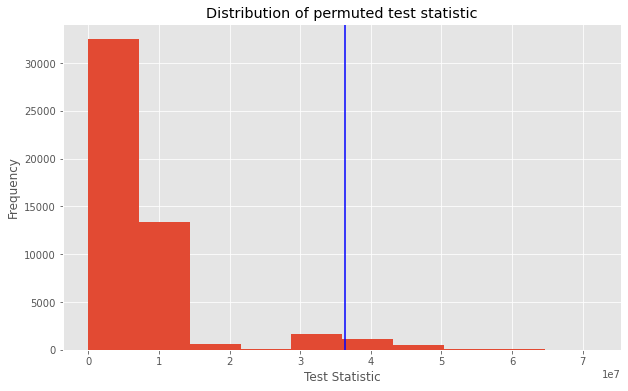

In [138]:
wnw_09_a, p_val_wnw_09_a = perm_test_2_samp(np.array(df_2009[df_2009['Winners']==1]['Net_Assets']),
                                            np.array(df_2009[df_2009['Winners']!=1]['Net_Assets']),
                                            size=50000)

0.1702129957193519
Reject Null Hypothesis as p-value  0.0 < alpha=0.05


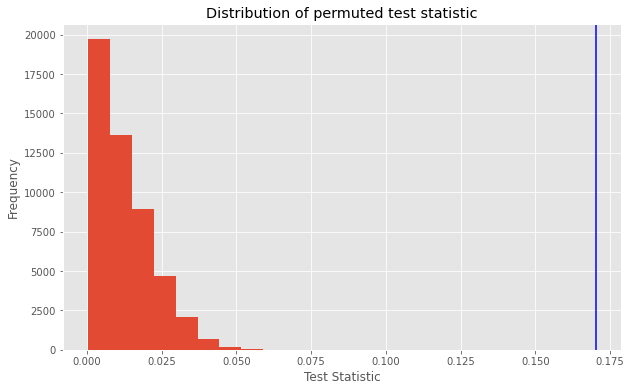

In [139]:
wnw_09_c, p_val_wnw_09_c = perm_test_2_samp(np.array(df_2009[df_2009['Winners']==1]['criminal_charge']),
                                            np.array(df_2009[df_2009['Winners']!=1]['criminal_charge']),
                                            size=50000)

0.34703756257910123
Reject Null Hypothesis as p-value  0.0 < alpha=0.05


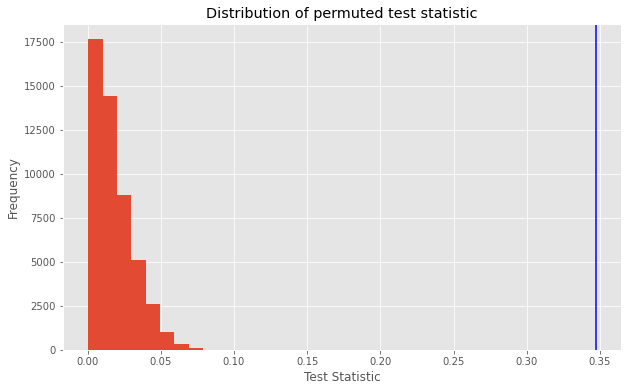

In [140]:
wnw_09_g, p_val_wnw_09_g = perm_test_2_samp(np.array(df_2009[df_2009['Winners']==1]['grad_h']),
                                            np.array(df_2009[df_2009['Winners']!=1]['grad_h']),
                                            size=50000)

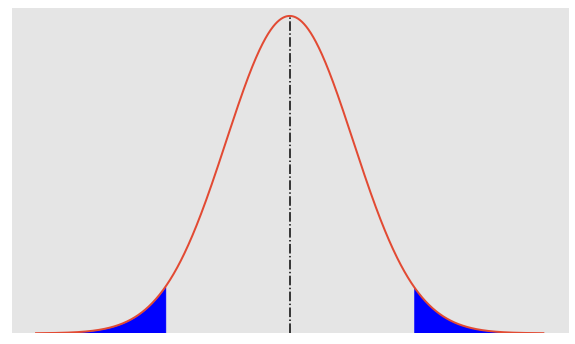

In [152]:
plt.figure(figsize=[10,6]);
x = np.linspace(-4,4,1000);
plt.plot(x, scipy.stats.norm.pdf(x,0,1),linewidth=2);
px=np.linspace(1.96,4,100);
plt.fill_between(px,scipy.stats.norm.pdf(px),color='b');
hx=np.linspace(-4,-1.96,100);
plt.fill_between(hx,scipy.stats.norm.pdf(hx),color='b');
plt.xticks([]);
plt.yticks([]);
plt.ylim(ymin=0,ymax=0.41);
plt.vlines(x=0,ymin=0,ymax=0.4,colors='black',linestyles='dashdot',linewidth=1.5);
plt.savefig('two_tail.png')

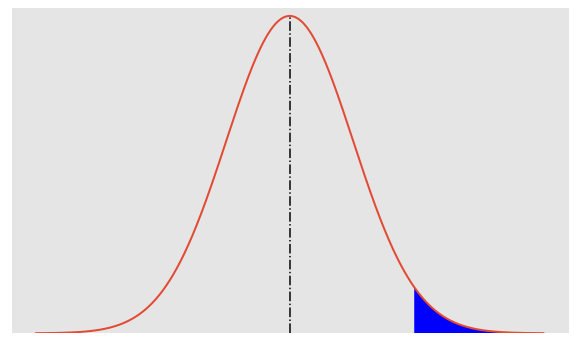

In [153]:
plt.figure(figsize=[10,6]);
x = np.linspace(-4,4,1000);
plt.plot(x, scipy.stats.norm.pdf(x,0,1),linewidth=2);
px=np.linspace(1.96,4,100);
plt.fill_between(px,scipy.stats.norm.pdf(px),color='b');
plt.xticks([]);
plt.yticks([]);
plt.ylim(ymin=0,ymax=0.41);
plt.vlines(x=0,ymin=0,ymax=0.4,colors='black',linestyles='dashdot',linewidth=1.5);
plt.savefig('right_tail.png')

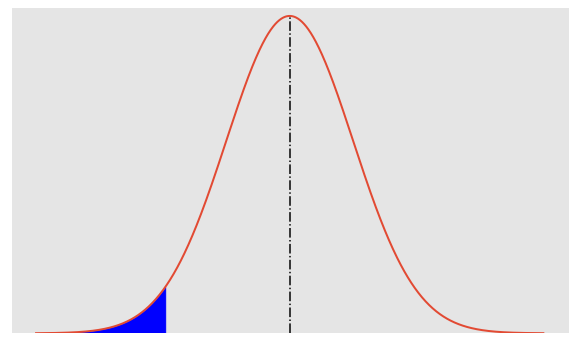

In [154]:
plt.figure(figsize=[10,6]);
x = np.linspace(-4,4,1000);
plt.plot(x, scipy.stats.norm.pdf(x,0,1),linewidth=2);
hx=np.linspace(-4,-1.96,100);
plt.fill_between(hx,scipy.stats.norm.pdf(hx),color='b');
plt.xticks([]);
plt.yticks([]);
plt.ylim(ymin=0,ymax=0.41);
plt.vlines(x=0,ymin=0,ymax=0.4,colors='black',linestyles='dashdot',linewidth=1.5);
plt.savefig('left_tail.png')